# Predict Titanic survival data using random forest / SVM

In [1]:
library(Hmisc)
library("caret")
library("rpart")
library("tree")
library("e1071")
library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function
library(randomForest)
set.seed(1)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

system("ls ../input")

# Read data
train <- read.csv("../input/train.csv" , stringsAsFactors = FALSE)
test  <- read.csv("../input/test.csv",   stringsAsFactors = FALSE)

# Any results you write to the current directory are saved as output.

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘caret’

The following object is masked from ‘package:survival’:

    cluster


Attaching package: ‘e1071’

The following object is masked from ‘package:Hmisc’:

    impute

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



Look at the first 6 rows of our training set

In [2]:
head(train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


Look at the structure of our training set

In [3]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [4]:
describe(train)

train 

 12  Variables      891  Observations
--------------------------------------------------------------------------------
PassengerId 
       n  missing distinct     Info     Mean      Gmd      .05      .10 
     891        0      891        1      446    297.3     45.5     90.0 
     .25      .50      .75      .90      .95 
   223.5    446.0    668.5    802.0    846.5 

lowest :   1   2   3   4   5, highest: 887 888 889 890 891
--------------------------------------------------------------------------------
Survived 
       n  missing distinct     Info      Sum     Mean      Gmd 
     891        0        2     0.71      342   0.3838   0.4735 

--------------------------------------------------------------------------------
Pclass 
       n  missing distinct     Info     Mean      Gmd 
     891        0        3     0.81    2.309   0.8631 
                            
Value          1     2     3
Frequency    216   184   491
Proportion 0.242 0.207 0.551
---------------------------

Do some light transformations, including making Sex and Embarked factors

In [5]:
# A function to extract features
  
extractFeatures <- function(data) {
  features <- c("Pclass",
                "Age",
                "Sex",
                "Parch",
                "SibSp",
                "Fare",
                "Embarked")
  fea <- data[,features]
  fea$Age[is.na(fea$Age)] <- -1
  fea$Fare[is.na(fea$Fare)] <- median(fea$Fare, na.rm=TRUE)
  fea$Embarked[fea$Embarked==""] = "S"
  fea$Sex      <- as.factor(fea$Sex)
  fea$Embarked <- as.factor(fea$Embarked)
  #fea <- cbind(fea, fea$Age * fea$Age)
    return(fea)
}

In [6]:
summary(extractFeatures(train))

     Pclass           Age           Sex          Parch            SibSp      
 Min.   :1.000   Min.   :-1.0   female:314   Min.   :0.0000   Min.   :0.000  
 1st Qu.:2.000   1st Qu.: 6.0   male  :577   1st Qu.:0.0000   1st Qu.:0.000  
 Median :3.000   Median :24.0                Median :0.0000   Median :0.000  
 Mean   :2.309   Mean   :23.6                Mean   :0.3816   Mean   :0.523  
 3rd Qu.:3.000   3rd Qu.:35.0                3rd Qu.:0.0000   3rd Qu.:1.000  
 Max.   :3.000   Max.   :80.0                Max.   :6.0000   Max.   :8.000  
      Fare        Embarked
 Min.   :  0.00   C:168   
 1st Qu.:  7.91   Q: 77   
 Median : 14.45   S:646   
 Mean   : 32.20           
 3rd Qu.: 31.00           
 Max.   :512.33           

In [7]:
summary(extractFeatures(test))

     Pclass           Age            Sex          Parch            SibSp       
 Min.   :1.000   Min.   :-1.00   female:152   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1.000   1st Qu.: 9.00   male  :266   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :3.000   Median :24.00                Median :0.0000   Median :0.0000  
 Mean   :2.266   Mean   :23.84                Mean   :0.3923   Mean   :0.4474  
 3rd Qu.:3.000   3rd Qu.:35.75                3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :3.000   Max.   :76.00                Max.   :9.0000   Max.   :8.0000  
      Fare         Embarked
 Min.   :  0.000   C:102   
 1st Qu.:  7.896   Q: 46   
 Median : 14.454   S:270   
 Mean   : 35.577           
 3rd Qu.: 31.472           
 Max.   :512.329           

# Fit Random Forests

In [8]:
rf <- randomForest(extractFeatures(train), as.factor(train$Survived), ntree=100, importance=TRUE)
rf


Call:
 randomForest(x = extractFeatures(train), y = as.factor(train$Survived),      ntree = 100, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 2

        OOB estimate of  error rate: 16.61%
Confusion matrix:
    0   1 class.error
0 501  48  0.08743169
1 100 242  0.29239766

In [9]:
# create submission file
submission <- data.frame( PassengerId= test$PassengerId )  # create a dataframe
# using model rf fit on training data to predict test data
submission$Survived <- predict( rf, extractFeatures(test) )  
# write results to CSV file
write.csv(submission, file = "1_random_forest_r_submission.csv", row.names=FALSE)
# plot importance of preditors
imp <- importance(rf, type=1 )
imp

,MeanDecreaseAccuracy
Pclass,17.704293
Age,11.397121
Sex,36.992422
Parch,12.724857
SibSp,8.429497
Fare,14.836648
Embarked,8.476183


# Fit classification tree

In [13]:
# Classification Tree with rpart
library(rpart)

# grow tree 
fol= formula( as.factor(Survived) ~ Pclass + Age + Sex + Parch + SibSp + Fare + Embarked)
fit <- rpart( fol, data=train, method= "class")

n= 891 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 891 342 0 (0.61616162 0.38383838)  
    2) Sex=male 577 109 0 (0.81109185 0.18890815)  
      4) Age>=6.5 553  93 0 (0.83182640 0.16817360) *
      5) Age< 6.5 24   8 1 (0.33333333 0.66666667)  
       10) SibSp>=2.5 9   1 0 (0.88888889 0.11111111) *
       11) SibSp< 2.5 15   0 1 (0.00000000 1.00000000) *
    3) Sex=female 314  81 1 (0.25796178 0.74203822)  
      6) Pclass>=2.5 144  72 0 (0.50000000 0.50000000)  
       12) Fare>=23.35 27   3 0 (0.88888889 0.11111111) *
       13) Fare< 23.35 117  48 1 (0.41025641 0.58974359)  
         26) Embarked=S 63  31 0 (0.50793651 0.49206349)  
           52) Fare< 10.825 37  15 0 (0.59459459 0.40540541) *
           53) Fare>=10.825 26  10 1 (0.38461538 0.61538462)  
            106) Fare>=17.6 10   3 0 (0.70000000 0.30000000) *
            107) Fare< 17.6 16   3 1 (0.18750000 0.81250000) *
         27) Embarked=C,Q 54  16 1 (0.29629630 0.70370370) *
     

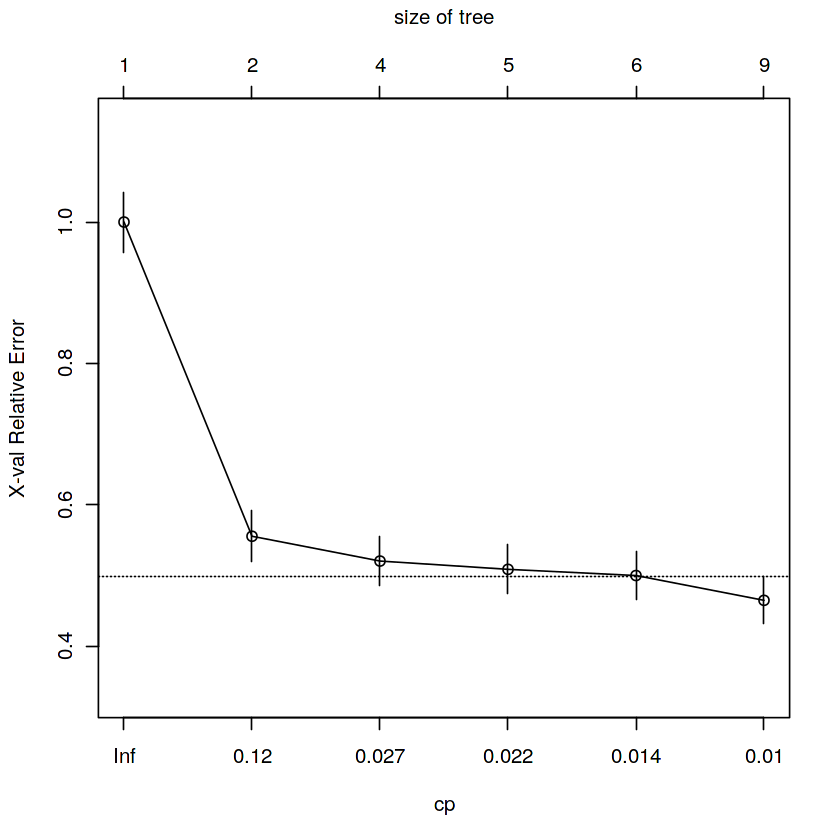

In [14]:
print(fit)     #print results  
printcp(fit)   #display cp table  
plotcp(fit)    #plot cross-validation results 
#rsq.rpart(fit) #plot approximate R-squared and relative error for different splits (2 plots). labels are only appropriate for the "anova" method.  
summary(fit)   #detailed results including surrogate splits  

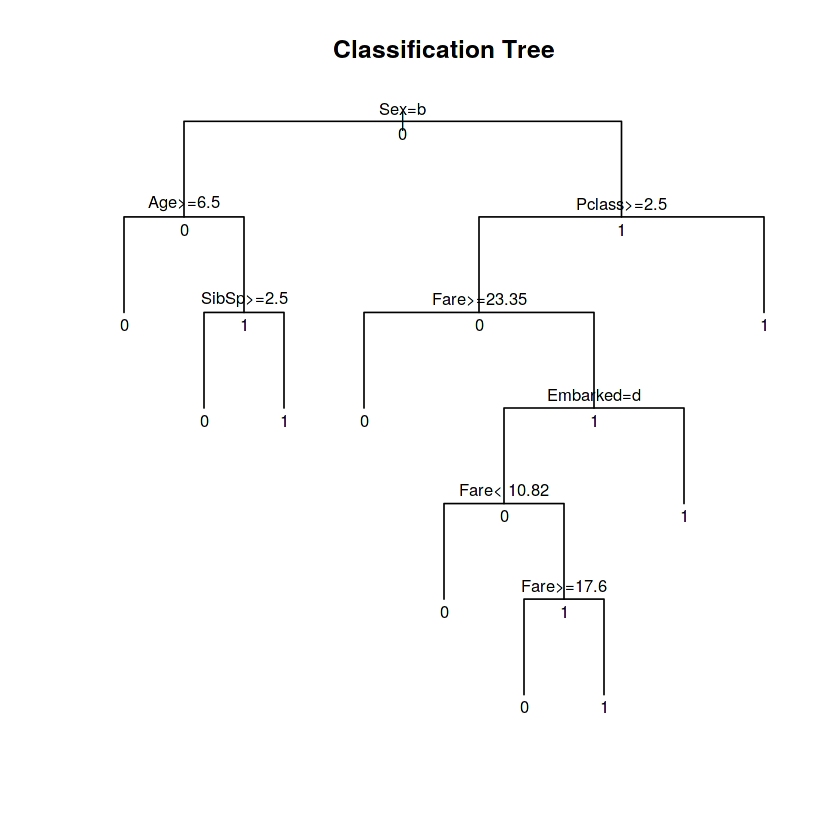

In [15]:
 # plot tree 
plot(fit, uniform=TRUE, main="Classification Tree")      #plot decision tree  
text(fit, use.n=FALSE, all=TRUE, cex=.8 )      #label the decision tree plot  